## NY Property Sales - Regression problem

Descrição da base de dados:

This dataset is a record of every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period.

Content

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

- **BOROUGH**: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).
- **BLOCK**; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL.
- **BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE**: The type of building at various points in time. See the glossary linked to below.

Glossary of therms: http://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf

Building Classifications Glossary: https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

    
Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

- Many sales occur with a nonsensically small dollar amount: 0 value most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.
- This dataset uses the financial definition of a building/building unit, for tax purposes. In case a single entity owns the building in question, a sale covers the value of the entire building. In case a building is owned piecemeal by its residents (a condominium), a sale refers to a single apartment (or group of apartments) owned by some individual.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('../data/nyc-rolling-sales.csv',  encoding="ISO-8859-1", na_values=' -  ')

In [3]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616.0,18690.0,1900,2,C7,NaN,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212.0,7803.0,1900,2,C7,NaN,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      84548 non-null  int64  
 1   BOROUGH                         84548 non-null  int64  
 2   NEIGHBORHOOD                    84548 non-null  object 
 3   BUILDING CLASS CATEGORY         84548 non-null  object 
 4   TAX CLASS AT PRESENT            84548 non-null  object 
 5   BLOCK                           84548 non-null  int64  
 6   LOT                             84548 non-null  int64  
 7   EASE-MENT                       84548 non-null  object 
 8   BUILDING CLASS AT PRESENT       84548 non-null  object 
 9   ADDRESS                         84548 non-null  object 
 10  APARTMENT NUMBER                84548 non-null  object 
 11  ZIP CODE                        84548 non-null  int64  
 12  RESIDENTIAL UNITS               

### Preparing and Cleaning Data

In [5]:
def rename_column_names(col):
    return col.lower().replace(' ', '_').replace('-', '_')

In [6]:
new_columns = []
for col in df.columns:
    new_columns.append(rename_column_names(col))
    
df.columns = new_columns

**First, the object type columns**

In [7]:
df_object = df.select_dtypes('object')
df_object.head()

,neighborhood,building_class_category,tax_class_at_present,ease_ment,building_class_at_present,address,apartment_number,building_class_at_time_of_sale,sale_date
0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,,C2,153 AVENUE B,,C2,2017-07-19 00:00:00
1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,,C7,234 EAST 4TH STREET,,C7,2016-12-14 00:00:00
2,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,,C7,197 EAST 3RD STREET,,C7,2016-12-09 00:00:00
3,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,,C4,154 EAST 7TH STREET,,C4,2016-09-23 00:00:00
4,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,,C2,301 EAST 10TH STREET,,C2,2016-11-17 00:00:00


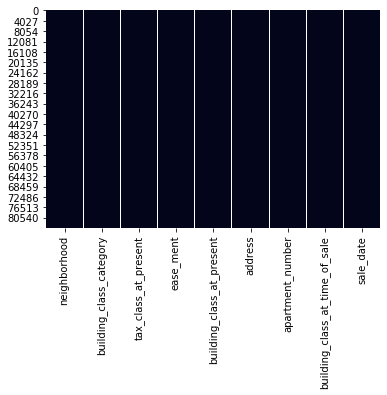

In [8]:
sns.heatmap(df_object.isnull(), cbar=False)

In [9]:
df_object.ease_ment.unique()

array([' '], dtype=object)

    A feature "ease_ment" não possui nenhum valor relevante para análise, neste caso vou excluí-la do dataframe junto com a feature "sale_date".

In [10]:
df_object.drop(columns=['ease_ment'], inplace=True)
df.drop(columns=['ease_ment'], inplace=True)

df_object.drop(columns=['sale_date'], inplace=True)
df.drop(columns=['sale_date'], inplace=True)

/home/guilherme/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
df_object['apartment_number'].value_counts()

         65496
4          298
3A         295
3B         275
2          275
         ...  
3J1          1
LA           1
NT68A        1
5-G          1
22J          1
Name: apartment_number, Length: 3989, dtype: int64

    Essa coluna nos diz que grande parte(65496) dos registros da base não possuem um número de apartamento, ou seja, não são apartamentos podendo ser casas residenciais ou comércios. Talvez, para efeito de análise podemos criar uma nova feature baseada em "apartment_number" que nos diz se o registro é uma casa ou um apartamento.

**Cleaning the numerical features**

In [12]:
df_numerical = df.select_dtypes('number')
df_numerical.head()

,unnamed:_0,borough,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,sale_price
0,4,1,392,6,10009,5,0,5,1633.0,6440.0,1900,2,6625000.0
1,5,1,399,26,10009,28,3,31,4616.0,18690.0,1900,2,NaN
2,6,1,399,39,10009,16,1,17,2212.0,7803.0,1900,2,NaN
3,7,1,402,21,10009,10,0,10,2272.0,6794.0,1913,2,3936272.0
4,8,1,404,55,10009,6,0,6,2369.0,4615.0,1900,2,8000000.0


    Aqui é notável que as features "total_units" é a soma de "residentual_units" e "commercial_units", portanto vamos utilizar somente a feature "total_units".

In [13]:
df_numerical.drop('unnamed:_0', axis=1, inplace=True)
df.drop('unnamed:_0', axis=1, inplace=True)

df_numerical.drop('residential_units', axis=1, inplace=True)
df.drop('residential_units', axis=1, inplace=True)

df_numerical.drop('commercial_units', axis=1, inplace=True)
df.drop('commercial_units', axis=1, inplace=True)

df_numerical.drop('zip_code', axis=1, inplace=True)
df.drop('zip_code', axis=1, inplace=True)

/home/guilherme/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


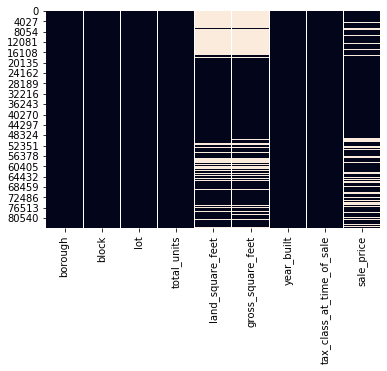

In [14]:
sns.heatmap(df_numerical.isnull(), cbar=False)

In [15]:
null_cols = ['land_square_feet', 'gross_square_feet', 'sale_price']

for col in null_cols:
    print("{}: {:.2f}% of null values".format(col, (df[col].isnull().sum() / len(df[col]) * 100)))

land_square_feet: 31.05% of null values
gross_square_feet: 32.66% of null values
sale_price: 17.22% of null values


### Data Inspection

    Aqui vamos explorar como as variáveis se comportam em relação à nossa variável alvo, no caso, sale_price.

In [16]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,apartment_number,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,5,1633.0,6440.0,1900,2,C2,6625000.0
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,31,4616.0,18690.0,1900,2,C7,NaN
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,17,2212.0,7803.0,1900,2,C7,NaN
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10,2272.0,6794.0,1913,2,C4,3936272.0
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,6,2369.0,4615.0,1900,2,C2,8000000.0


In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
borough,84548.0,2.998758e+00,1.289790e+00,1.0,2.00,3.0,4.0,5.000000e+00
block,84548.0,4.237219e+03,3.568263e+03,1.0,1322.75,3311.0,6281.0,1.632200e+04
lot,84548.0,3.762240e+02,6.581368e+02,1.0,22.00,50.0,1001.0,9.106000e+03
total_units,84548.0,2.249184e+00,1.897258e+01,0.0,1.00,1.0,2.0,2.261000e+03
land_square_feet,58296.0,3.941676e+03,4.198397e+04,0.0,1650.00,2325.0,3500.0,4.252327e+06
gross_square_feet,56936.0,4.045707e+03,3.503249e+04,0.0,1046.75,1680.0,2560.0,3.750565e+06
year_built,84548.0,1.789323e+03,5.373450e+02,0.0,1920.00,1940.0,1965.0,2.017000e+03
tax_class_at_time_of_sale,84548.0,1.657485e+00,8.193412e-01,1.0,1.00,2.0,2.0,4.000000e+00
sale_price,69987.0,1.276456e+06,1.140526e+07,0.0,225000.00,530000.0,950000.0,2.210000e+09


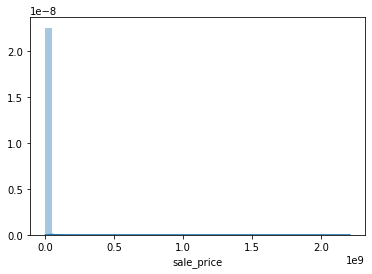

In [18]:
sns.distplot(df['sale_price'])

    Após alguns testes, usar o limite inferior 100000 foi mais efetivo do que utilizar o quartil 0.05 para que se tenha uma distribuição mais próxima a normal.

    Aqui foi utilizado o 95 quartil pois os modelos foram mais assertivos quando comparado ao 99 quartil.

In [19]:
q95 = df['sale_price'].quantile(0.95)
# q05 = df['sale_price'].quantile(0.05)

df = df[(df['sale_price'] > 100000) & (df['sale_price'] < q95)]
df['sale_price'].skew()

1.821455451597566

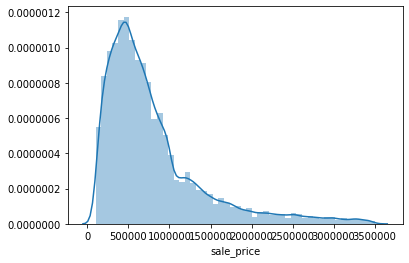

In [20]:
sns.distplot(df['sale_price'])

    Temos uma distribuição assimétrica à direita. Aqui é aplicado a transformação log(x) para diminuição da skewness com a finalidade

In [21]:
df['sale_price_log'] = np.log(df['sale_price'])

Skewness: 0.02929983378399524
Kurtosis: -0.268805869152394


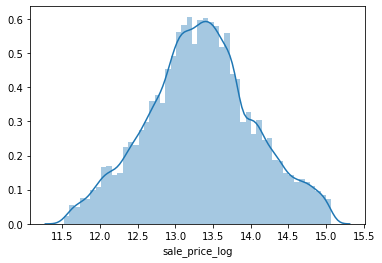

In [22]:
sns.distplot(df['sale_price_log'])

print("Skewness: {}\nKurtosis: {}".format(df['sale_price_log'].skew(), df['sale_price_log'].kurtosis()))

Fazendo o mesmo para as features land_square_feet e gross_square_feet

In [23]:
q99 = df['land_square_feet'].quantile(0.99)
q05 = df['land_square_feet'].quantile(0.05)

df = df[(df['land_square_feet'] > q05) & (df['land_square_feet'] < q99)]

1.881758146988164

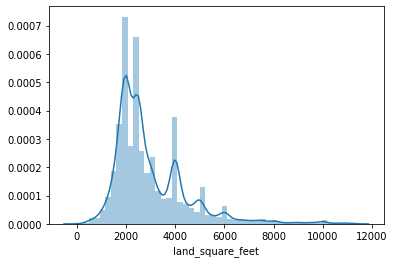

In [24]:
sns.distplot(df['land_square_feet'])
df['land_square_feet'].skew()

In [25]:
df['land_square_feet_log'] = np.log(df['land_square_feet'])

0.1896296813233

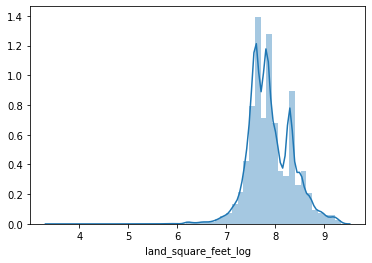

In [26]:
sns.distplot(df['land_square_feet_log'])
df['land_square_feet_log'].skew()

In [27]:
q99 = df['gross_square_feet'].quantile(0.99)
q05 = df['gross_square_feet'].quantile(0.05)

df = df[(df['gross_square_feet'] > q05) & (df['gross_square_feet'] < q99)]
df['gross_square_feet'].skew()

1.8029801189410952

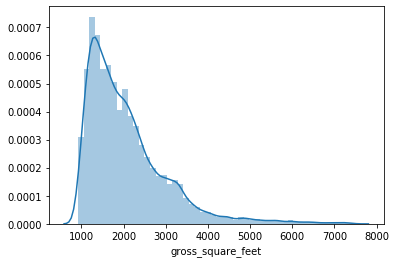

In [28]:
sns.distplot(df['gross_square_feet'])

In [29]:
df['gross_square_feet_log'] = np.log(df['gross_square_feet'])

0.5581566949902116

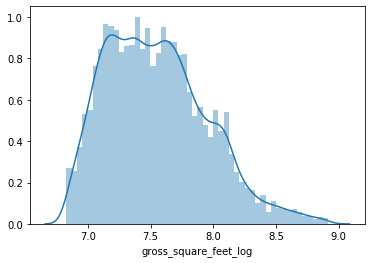

In [30]:
sns.distplot(df['gross_square_feet_log'])
df['gross_square_feet_log'].skew()

    Aqui vemos a relação entre land_square_feet e gross_square_feet

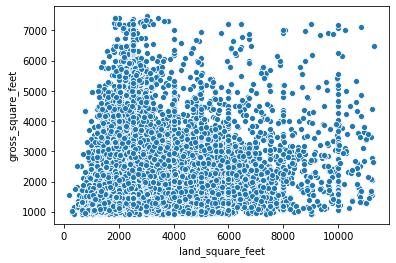

In [31]:
sns.scatterplot(data=df, x='land_square_feet', y='gross_square_feet')

In [32]:
df[['land_square_feet', 'gross_square_feet']].corr()

,land_square_feet,gross_square_feet
land_square_feet,1.00000,0.09016
gross_square_feet,0.09016,1.00000


In [33]:
borough_dic = {1: "Manhattan", 2: "Bronx", 3: "Brooklyn", 4: "Queens", 5: "Staten Island"}
df['borough_cat'] = df['borough'].map(borough_dic)

Text(0.5, 1.0, 'Borough count')

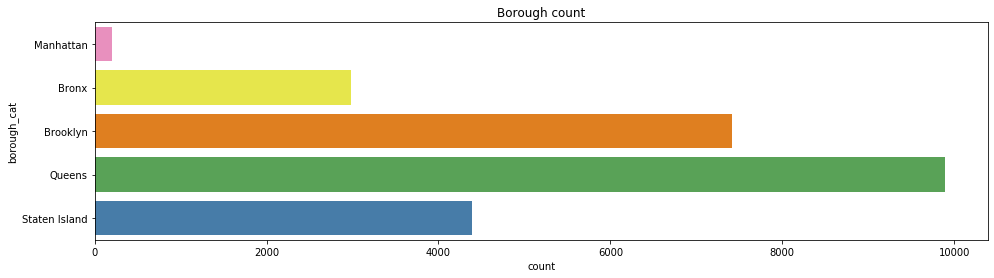

In [34]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.countplot(y='borough_cat', data=df, ax=ax, palette='Set1_r').set_title("Borough count")

Text(0.5, 1, 'sale_price X borough')

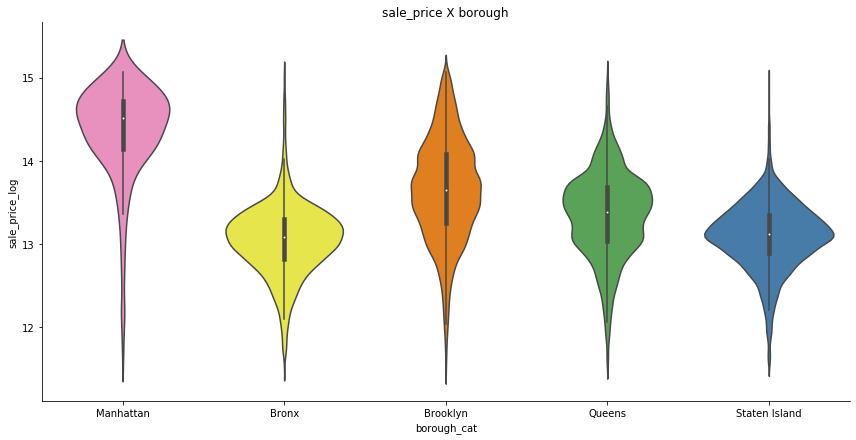

In [35]:
# Sale price log by region of the city
sns.catplot(x='borough_cat', y='sale_price_log', kind='violin',
            data=df, height=6, aspect=2, palette='Set1_r')
plt.title('sale_price X borough')

    Aqui vemos que as propriedades comercializadas no Bronx custam menos em relação as outras regiões de Nova Iorque, já as propriedades em Manhattan são as mais caras. Em Staten Island, maior parte dos preços estão mais próximo da média. No Brooklyn temos uma maior variabilidade nos preços.

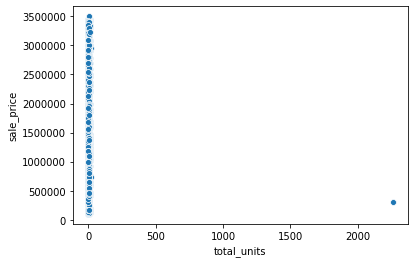

In [36]:
sns.scatterplot(data=df, x='total_units', y='sale_price')

In [37]:
df = df[df['total_units'] < 40]

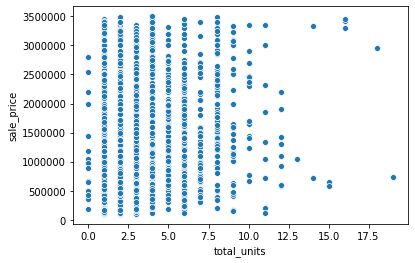

In [38]:
sns.scatterplot(data=df, x='total_units', y='sale_price')

    Com relação a variável year_built vamos construir uma nova variável que divide o ano de construção da propriedade por década. Assim conseguimos ter uma melhor visualização quando categorizadas dessa maneira além de poder usar essa nova variável transformada nos nossos modelos.

In [39]:
np.sort(df['year_built'].unique())

array([   0, 1800, 1847, 1870, 1871, 1880, 1881, 1890, 1891, 1896, 1899,
       1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [40]:
def year_built_transform(year):
    if ((year >= 0) & (year <= 1799)):
        return 0
    elif ((year >= 1800) & (year <= 1809)):
        return 1800
    elif ((year >= 1810) & (year <= 1819)):
        return 1810
    elif ((year >= 1820) & (year <= 1829)):
        return 1820
    elif ((year >= 1830) & (year <= 1839)):
        return 1830
    elif ((year >= 1840) & (year <= 1849)):
        return 1840
    elif ((year >= 1850) & (year <= 1859)):
        return 1850
    elif ((year >= 1860) & (year <= 1869)):
        return 1860
    elif ((year >= 1870) & (year <= 1879)):
        return 1870
    elif ((year >= 1880) & (year <= 1889)):
        return 1880
    elif ((year >= 1890) & (year <= 1899)):
        return 1890
    elif ((year >= 1900) & (year <= 1909)):
        return 1900
    elif ((year >= 1910) & (year <= 1919)):
        return 1910
    elif ((year >= 1920) & (year <= 1929)):
        return 1920
    elif ((year >= 1930) & (year <= 1939)):
        return 1930
    elif ((year >= 1940) & (year <= 1949)):
        return 1940
    elif ((year >= 1950) & (year <= 1959)):
        return 1950
    elif ((year >= 1960) & (year <= 1969)):
        return 1960
    elif ((year >= 1970) & (year <= 1979)):
        return 1970
    elif ((year >= 1980) & (year <= 1989)):
        return 1980
    elif ((year >= 1990) & (year <= 1999)):
        return 1990
    elif ((year >= 2000) & (year <= 2009)):
        return 2000
    elif ((year >= 2010) & (year <= 2019)):
        return 2010

In [41]:
df['year_built_cat'] = df['year_built'].apply(year_built_transform).copy()

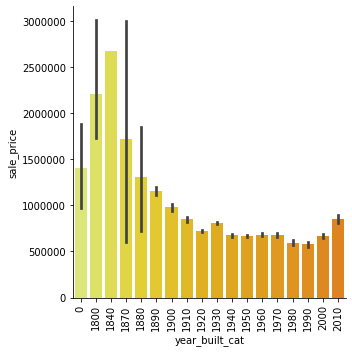

In [42]:
sns.catplot(x='year_built_cat', y='sale_price', data=df, kind='bar', palette='Wistia')
plt.xticks(rotation=90)
plt.tight_layout()

    A partir do gráfico, vemos que o período entre 1800 até 1880 possuem os preços mais caros com relação ao restante da base de dados porém com as barras de erro mais altas.

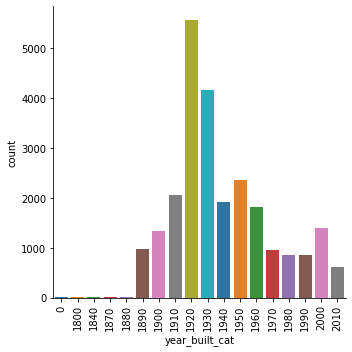

In [43]:
sns.catplot(x='year_built_cat', data=df, kind='count', palette='tab10')
plt.xticks(rotation=90)
plt.tight_layout()

    Após dividir year_built por década a partir de 1800, vemos no gráfico acima que a maioria das casas da base de dados são de 1890 até 2016. 

In [44]:
# sns.catplot(x='year_built_cat', y='sale_price_log', kind='violin',
#             data=df, height=6, aspect=4, palette='Set1_r')

In [45]:
df['building_class_category'].value_counts()

01 ONE FAMILY DWELLINGS                        11293
02 TWO FAMILY DWELLINGS                         9396
03 THREE FAMILY DWELLINGS                       2215
07 RENTALS - WALKUP APARTMENTS                  1078
22 STORE BUILDINGS                               274
14 RENTALS - 4-10 UNIT                           249
21 OFFICE BUILDINGS                               98
29 COMMERCIAL GARAGES                             78
30 WAREHOUSES                                     73
27 FACTORIES                                      36
37 RELIGIOUS FACILITIES                           33
05 TAX CLASS 1 VACANT LAND                        11
33 EDUCATIONAL FACILITIES                         10
35 INDOOR PUBLIC AND CULTURAL FACILITIES           7
32 HOSPITAL AND HEALTH FACILITIES                  7
38 ASYLUMS AND HOMES                               4
26 OTHER HOTELS                                    3
23 LOFT BUILDINGS                                  2
06 TAX CLASS 1 - OTHER                        

In [46]:
df['building_class_category'] = df['building_class_category'].str.strip()

In [47]:
# Como temos muitas classes nessa feature, vamos selecionar as classes mais frequentes
cols = ['01 ONE FAMILY DWELLINGS', '10 COOPS - ELEVATOR APARTMENTS',
        '02 TWO FAMILY DWELLINGS', '13 CONDOS - ELEVATOR APARTMENTS']

df = df[(df['building_class_category'] == cols[0]) |
   (df['building_class_category'] == cols[1]) |
   (df['building_class_category'] == cols[2]) |
   (df['building_class_category'] == cols[3])]

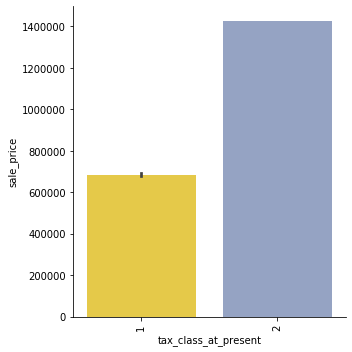

In [48]:
df = df[df['tax_class_at_present'] != ' ']
sns.catplot(y='sale_price', x='tax_class_at_present', data=df, kind='bar', palette='Set2_r')
plt.xticks(rotation=90)
plt.tight_layout()

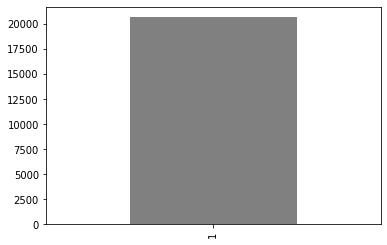

In [49]:
df['tax_class_at_time_of_sale'].value_counts().plot(kind='bar', color='gray')

## Modelagem 

In [50]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,apartment_number,total_units,...,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_price_log,land_square_feet_log,gross_square_feet_log,borough_cat,year_built_cat
1791,1,EAST VILLAGE,02 TWO FAMILY DWELLINGS,1,436,1,S2,138 1 AVENUE,,3,...,3360.0,1900,1,S2,3000000.0,14.914123,7.090077,8.119696,Manhattan,1900
4172,1,GREENWICH VILLAGE-WEST,01 ONE FAMILY DWELLINGS,1,585,69,A5,2 GROVE COURT,,1,...,1152.0,1901,1,A5,1375000.0,14.133964,5.950643,7.049255,Manhattan,1900
4173,1,GREENWICH VILLAGE-WEST,01 ONE FAMILY DWELLINGS,1,585,69,A5,2 GROVE COURT,,1,...,1152.0,1901,1,A5,1375000.0,14.133964,5.950643,7.049255,Manhattan,1900
4800,1,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1942,58,A4,288 W. 137TH STREET,,1,...,3036.0,1910,1,A4,2300000.0,14.648420,7.345365,8.018296,Manhattan,1910
4801,1,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,1,...,3200.0,1910,1,A9,1510000.0,14.227620,7.417580,8.070906,Manhattan,1910


#### Feature Selection

Inicialmente foram excluídas as features como "neighborhood", "adress", "apartment_number", "borough_cat", "year_built" e "sale_price", estas últimas porque outras features derivadas destas foram utilizadas. 

Abaixo foram testados modelos como Random Forest, Linear Regression, KNN e Lasso Regression. Após analisar os coeficientes gerados pelo Lasso Regression foi verificado que muitos dos coeficientes referentes as features "building_class_at_present", "building_class_at_time_of_sale", "building_class_category" e "tax_class_at_time_of_sale" foram zerados. Devido a característica .....[IR NO COURSERA PARA EMBASAR A FEATURE SELECTION] ... foi feita a feature selection

In [51]:
df_ml = df.drop(columns=['neighborhood', 'address', 'building_class_at_present', 'land_square_feet_log',
                         'apartment_number', 'year_built', 'building_class_at_time_of_sale',
                         'gross_square_feet_log', 'sale_price_log', 'borough_cat', 'tax_class_at_time_of_sale'],
                         axis=1)

df_ml.head()

,borough,building_class_category,tax_class_at_present,block,lot,total_units,land_square_feet,gross_square_feet,sale_price,year_built_cat
1791,1,02 TWO FAMILY DWELLINGS,1,436,1,3,1200.0,3360.0,3000000.0,1900
4172,1,01 ONE FAMILY DWELLINGS,1,585,69,1,384.0,1152.0,1375000.0,1900
4173,1,01 ONE FAMILY DWELLINGS,1,585,69,1,384.0,1152.0,1375000.0,1900
4800,1,01 ONE FAMILY DWELLINGS,1,1942,58,1,1549.0,3036.0,2300000.0,1910
4801,1,01 ONE FAMILY DWELLINGS,1,1960,41,1,1665.0,3200.0,1510000.0,1910


In [52]:
numerical_cols = ['land_square_feet', 'gross_square_feet', 'sale_price']
scalar = StandardScaler()
scalar.fit(df_ml[numerical_cols])
scalar = scalar.transform(df_ml[numerical_cols])

for i, col in enumerate(numerical_cols):
    df_ml[col] = scalar[:, i]
df_ml.head()

,borough,building_class_category,tax_class_at_present,block,lot,total_units,land_square_feet,gross_square_feet,sale_price,year_built_cat
1791,1,02 TWO FAMILY DWELLINGS,1,436,1,3,-1.214424,2.277142,5.616546,1900
4172,1,01 ONE FAMILY DWELLINGS,1,585,69,1,-1.766383,-0.996253,1.674397,1900
4173,1,01 ONE FAMILY DWELLINGS,1,585,69,1,-1.766383,-0.996253,1.674397,1900
4800,1,01 ONE FAMILY DWELLINGS,1,1942,58,1,-0.978354,1.796807,3.918390,1910
4801,1,01 ONE FAMILY DWELLINGS,1,1960,41,1,-0.899889,2.039939,2.001899,1910


In [53]:
df_ml = pd.get_dummies(data=df_ml, columns=['borough', 'tax_class_at_present', 'year_built_cat',
                                           'building_class_category'])

df_ml.head()

,block,lot,total_units,land_square_feet,gross_square_feet,sale_price,borough_1,borough_2,borough_3,borough_4,...,year_built_cat_1940,year_built_cat_1950,year_built_cat_1960,year_built_cat_1970,year_built_cat_1980,year_built_cat_1990,year_built_cat_2000,year_built_cat_2010,building_class_category_01 ONE FAMILY DWELLINGS,building_class_category_02 TWO FAMILY DWELLINGS
1791,436,1,3,-1.214424,2.277142,5.616546,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4172,585,69,1,-1.766383,-0.996253,1.674397,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4173,585,69,1,-1.766383,-0.996253,1.674397,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4800,1942,58,1,-0.978354,1.796807,3.918390,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4801,1960,41,1,-0.899889,2.039939,2.001899,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [54]:
y = df_ml.sale_price
X = df_ml.drop(columns='sale_price', axis=1)

### Lasso Regression

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

alpha = 0.00099
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train, y_train)

y_train_predicted = lasso_reg.predict(X_train)
RMSE_train = mean_squared_error(y_train, y_train_predicted, squared=True)
MAE_train = mean_absolute_error(y_train, y_train_predicted)
r2 = r2_score(y_train, y_train_predicted)
print("RMSE train: {:.4f} | MAE train: {:.4f} | r2: {:.4f}".format(RMSE_train, MAE_train, r2))

y_test_predicted = lasso_reg.predict(X_test)      
RMSE_test = mean_squared_error(y_test, y_test_predicted, squared=True)
MAE_test = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)
print("RMSE test: {:.4f}  | MAE test: {:.4f} | r2: {:.4f}".format(RMSE_test, MAE_test, r2))

RMSE train: 0.5980 | MAE train: 0.5036 | r2: 0.4119
RMSE test: 0.5453  | MAE test: 0.4950 | r2: 0.4323


In [56]:
for col, coef in zip(X.columns, lasso_reg.coef_):
    print(col, coef)

block -9.181962558321033e-05
lot -8.704091833884103e-06
total_units -0.03657185041387755
land_square_feet 0.17533301515732178
gross_square_feet 0.3376520147955142
borough_1 1.2546033712615432
borough_2 -0.9397944486248762
borough_3 0.24521820982346187
borough_4 -0.0
borough_5 -0.9177982606460142
tax_class_at_present_1 0.0
tax_class_at_present_2 0.0
year_built_cat_0 -0.0
year_built_cat_1840 0.0
year_built_cat_1870 0.0
year_built_cat_1880 0.0
year_built_cat_1890 0.26917794022889246
year_built_cat_1900 0.01277608551783182
year_built_cat_1910 -0.1177958936489595
year_built_cat_1920 -0.04618597833803863
year_built_cat_1930 -0.030268043176575478
year_built_cat_1940 -0.012162509368964345
year_built_cat_1950 -0.010898415513414255
year_built_cat_1960 -0.03179507123455193
year_built_cat_1970 0.006570244562724765
year_built_cat_1980 -0.0
year_built_cat_1990 0.02756528959991223
year_built_cat_2000 0.0
year_built_cat_2010 0.049427390694957704
building_class_category_01 ONE FAMILY DWELLINGS 0.060304

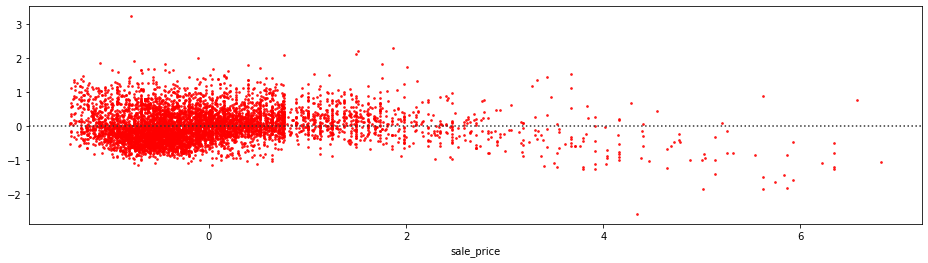

In [57]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.residplot(x=y_test, y=y_test_predicted, color='r', scatter_kws={"s": 3}, ax=ax)

In [58]:
cv = cross_val_score(Lasso(alpha=alpha), X, y, cv=3)
print(cv)

[ 0.01266675  0.29767546 -2.21372171]


### Random Forest

    A escolha de utilizar Random forest se deve pela boa perfomance em grande quantidade de features e dados, além de ser um modelo de fácil entendimento. A desvantagem desse algoritmo é que tende overfitting quando há ruídos tanto em tarefas de classificação quanto de regressão e para features categóricas que possuem muitos valores distintos o modelo acaba enviesado em favor desses diferentes valores.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

y_train_predicted = rf_reg.predict(X_train)
RMSE_train = mean_squared_error(y_train, y_train_predicted, squared=True)
MAE_train = mean_absolute_error(y_train, y_train_predicted)
r2 = r2_score(y_train, y_train_predicted)
print("RMSE train: {:.4f} | MAE train: {:.4f} | r2: {:.4f}".format(RMSE_train, MAE_train, r2))

y_test_predicted = rf_reg.predict(X_test)      
RMSE_test = mean_squared_error(y_test, y_test_predicted, squared=True)
MAE_test = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)
print("RMSE test: {:.4f}  | MAE test: {:.4f} | r2: {:.4f}".format(RMSE_test, MAE_test, r2))

RMSE train: 0.0555 | MAE train: 0.1456 | r2: 0.9457
RMSE test: 0.3207  | MAE test: 0.3636 | r2: 0.6648


In [60]:
cv = cross_val_score(RandomForestRegressor(n_jobs=-1), X, y, cv=3, n_jobs=-1)
print(cv)

[-0.31650001  0.4170971  -6.04085683]


    Devido à diferença entre as métricas de treino e teste, será utilizado GridSearch. Mesmo sendo muito custoso, o processo abaixo demorou por volta de 8 minutos para ser executado. O tempo de execução varia em função da configuração do computador.

In [61]:
# Utilizando GridSearch para diminuir o overfitting do modelo
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [90, 100],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 500]
# }

# rf = RandomForestRegressor()

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)
# print("best params: {}".format(grid_search.best_params_))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

rf_reg = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=3, n_jobs=-1,
                               min_samples_leaf=3, min_samples_split=8, n_estimators=200)
rf_reg.fit(X_train, y_train)

y_train_predicted = rf_reg.predict(X_train)
RMSE_train = mean_squared_error(y_train, y_train_predicted, squared=True)
MAE_train = mean_absolute_error(y_train, y_train_predicted)
r2 = r2_score(y_train, y_train_predicted)
print("RMSE train: {:.4f} | MAE train: {:.4f} | r2: {:.4f}".format(RMSE_train, MAE_train, r2))

y_test_predicted = rf_reg.predict(X_test)      
RMSE_test = mean_squared_error(y_test, y_test_predicted, squared=True)
MAE_test = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)
print("RMSE test: {:.4f}  | MAE test: {:.4f} | r2: {:.4f}".format(RMSE_test, MAE_test, r2))

RMSE train: 0.3366 | MAE train: 0.3567 | r2: 0.6704
RMSE test: 0.4092  | MAE test: 0.4056 | r2: 0.5723


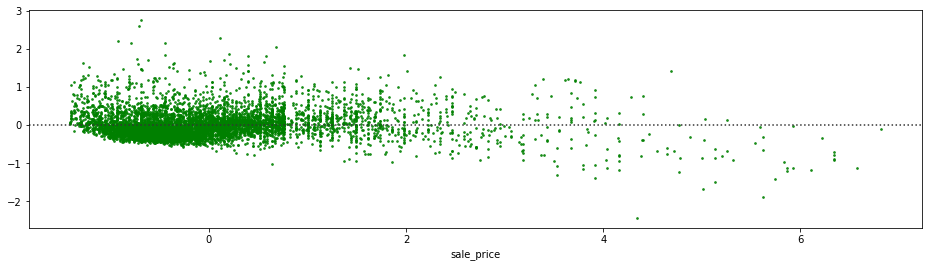

In [72]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.residplot(x=y_test, y=y_test_predicted, color='g', scatter_kws={"s": 3}, ax=ax)

In [73]:
# Cross-validation
rf_reg = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=3, n_jobs=-1,
                               min_samples_leaf=3, min_samples_split=8, n_estimators=200)

cv = cross_val_score(rf_reg, X, y, cv=3)
print(cv)

[ 0.03359037  0.3404334  -1.38683502]


### Linear Regression

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ln_reg = LinearRegression(n_jobs=-1)
ln_reg.fit(X_train, y_train)

y_train_predicted = ln_reg.predict(X_train)
RMSE_train = mean_squared_error(y_train, y_train_predicted, squared=True)
MAE_train = mean_absolute_error(y_train, y_train_predicted)
r2 = r2_score(y_train, y_train_predicted)
print("RMSE train: {:.4f} | MAE train: {:.4f} | r2: {:.4f}".format(RMSE_train, MAE_train, r2))

y_test_predicted = ln_reg.predict(X_test)      
RMSE_test = mean_squared_error(y_test, y_test_predicted, squared=True)
MAE_test = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)
print("RMSE test: {:.4f}  | MAE test: {:.4f} | r2: {:.4f}".format(RMSE_test, MAE_test, r2))

print(ln_reg.coef_)

RMSE train: 0.5948 | MAE train: 0.5029 | r2: 0.4151
RMSE test: 0.5426  | MAE test: 0.4942 | r2: 0.4351
[-9.17664319e-05 -1.70997136e-05 -2.15503273e-02  1.84256038e-01
  3.30289647e-01  1.62442945e+00 -9.41127154e-01  2.57220566e-01
  4.20783640e-03 -9.44730693e-01 -4.08006962e-15  1.55431223e-15
 -7.86601709e-01  3.60852909e+00  2.38415510e+00  8.17474141e-01
 -1.92814591e-01 -4.53143524e-01 -6.15316695e-01 -5.38465584e-01
 -5.24719329e-01 -5.13039929e-01 -5.09910656e-01 -5.26184386e-01
 -4.31718632e-01 -4.82617719e-01 -4.08805091e-01 -4.50872074e-01
 -3.75948411e-01  4.06887972e-02 -4.06887972e-02]


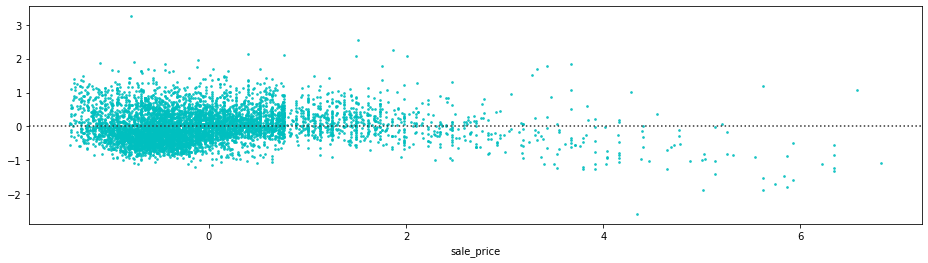

In [66]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.residplot(x=y_test, y=y_test_predicted, color='c', scatter_kws={"s": 3}, ax=ax)

In [67]:
cv = cross_val_score(LinearRegression(n_jobs=-1), X, y, cv=3)
print(cv)

[ 0.05045481  0.29809423 -3.009603  ]


### KNN

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

knn = KNeighborsRegressor(n_neighbors=13, n_jobs=-1)
knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)
RMSE_train = mean_squared_error(y_train, y_train_predicted, squared=True)
MAE_train = mean_absolute_error(y_train, y_train_predicted)
r2 = r2_score(y_train, y_train_predicted)
print("RMSE train: {:.4f} | MAE train: {:.4f} | r2: {:.4f}".format(RMSE_train, MAE_train, r2))

y_test_predicted = knn.predict(X_test)      
RMSE_test = mean_squared_error(y_test, y_test_predicted, squared=True)
MAE_test = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)
print("RMSE test: {:.4f}  | MAE test: {:.4f} | r2: {:.4f}".format(RMSE_test, MAE_test, r2))

RMSE train: 0.6683 | MAE train: 0.5386 | r2: 0.3428
RMSE test: 0.7219  | MAE test: 0.5718 | r2: 0.2484


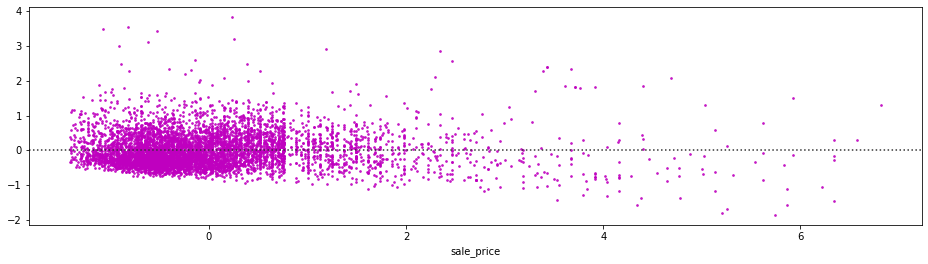

In [69]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.residplot(x=y_test, y=y_test_predicted, color='m', scatter_kws={"s": 3}, ax=ax)

In [70]:
knn = KNeighborsRegressor(n_neighbors=13, n_jobs=-1)
cv = cross_val_score(knn, X, y, cv=3)
print(cv)

[-0.09868449 -0.2518134  -7.44708774]


Entre os modelos utilizados, o RandomForest é o modelo que possui as métricas mais assertivas quando comparados com os outros modelos tanto nos dados de teste e treino. 